In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import tensorflow as tf
import sis
import clustering
from rationale_objects import Image, SIS_RATIONALE_KEY

Using TensorFlow backend.


In [14]:
sis.tf_config(cuda_visible_devices='2')

In [17]:
MNIST_BASEDIR = '../../sis_data/mnist'
DATA_DIR = os.path.join(MNIST_BASEDIR, 'data')
CNN_RATIONALES_BASEDIR = os.path.join(MNIST_BASEDIR, 'rationales')
MLP_RATIONALES_BASEDIR = os.path.join(MNIST_BASEDIR, 'mlp_rationales')
figures_dir = '../figures/mnist'

## Load data

In [19]:
digit = 4

cnn_images = clustering.mnist_load_images_from_dir(os.path.join(CNN_RATIONALES_BASEDIR, str(digit)))
mlp_images = clustering.mnist_load_images_from_dir(os.path.join(MLP_RATIONALES_BASEDIR, str(digit)))

## Clustering

In [20]:
cnn_sis, cnn_sis_images = clustering.mnist_get_all_sis_and_images(cnn_images, rationale_key='greedy')
mlp_sis, mlp_sis_images = clustering.mnist_get_all_sis_and_images(mlp_images)

print('# CNN SIS: ', len(cnn_sis))
print('# MLP SIS: ', len(mlp_sis))

# CNN SIS:  4031
# MLP SIS:  2062


In [21]:
all_sis = cnn_sis + mlp_sis
all_sis_images = np.concatenate((cnn_sis_images, mlp_sis_images))
print('Total # rationales: ', len(all_sis))

Total # rationales:  6093


In [22]:
all_sis_energy_dist_file = os.path.join(MNIST_BASEDIR, 'energy_dists', 'all_sis_cnn_and_mlp.npz')

In [10]:
%%time
# Build energy distance matrix and write to file
energy_dist_matrix = clustering.compute_energy_dists(all_sis)
clustering.save_matrix(energy_dist_matrix, all_sis_energy_dist_file)

CPU times: user 39min 49s, sys: 7.11 s, total: 39min 56s
Wall time: 39min 56s


In [23]:
energy_dist_matrix = clustering.load_matrix(all_sis_energy_dist_file)

In [24]:
# Energy distance statistics
print('Median: ', np.median(energy_dist_matrix))
print('Mean: ', np.mean(energy_dist_matrix))
print('Max: ', np.max(energy_dist_matrix))
print('Stdev: ', np.std(energy_dist_matrix))

Median:  1.4008780044171303
Mean:  1.467678929916077
Max:  4.505199432330865
Stdev:  0.4883787448177883


In [25]:
cluster_to_core_idxs, cluster_to_noncore_idxs, labels = clustering.cluster(
    energy_dist_matrix,
    eps=0.45,
    min_samples=15,
)

cluster_label_to_cluster = clustering.get_label_to_cluster(labels)

Estimated number of clusters: 9
# core samples:  1131


In [29]:
count_cnn_idxs = lambda idxs: sum((1 for i in idxs if i < len(cnn_sis)))

cluster_to_name_str = {}

for cluster_num, cluster in sorted(cluster_label_to_cluster.items()):
    num_cnn_idxs = count_cnn_idxs(cluster)
    num_mlp_idxs = len(cluster) - num_cnn_idxs
    perc_cnn = float(num_cnn_idxs) / len(cluster) * 100.0
    perc_mlp = float(num_mlp_idxs) / len(cluster) * 100.0
    if cluster_num == -1:
        cluster_num_to_print = cluster_num
    else:
        cluster_num_to_print = cluster_num + 1
    cluster_to_name_str[cluster_num] = '$C_{%d}$ (CNN: %d%%)' % (cluster_num_to_print, np.around(perc_cnn))
    print('Cluster %s:  %.1f%% CNN  /  %.1f%% MLP' % (str(cluster_num), perc_cnn, perc_mlp))

Cluster -1:  87.4% CNN  /  12.6% MLP
Cluster 0:  100.0% CNN  /  0.0% MLP
Cluster 1:  100.0% CNN  /  0.0% MLP
Cluster 2:  4.7% CNN  /  95.3% MLP
Cluster 3:  100.0% CNN  /  0.0% MLP
Cluster 4:  100.0% CNN  /  0.0% MLP
Cluster 5:  100.0% CNN  /  0.0% MLP
Cluster 6:  100.0% CNN  /  0.0% MLP
Cluster 7:  100.0% CNN  /  0.0% MLP
Cluster 8:  0.0% CNN  /  100.0% MLP


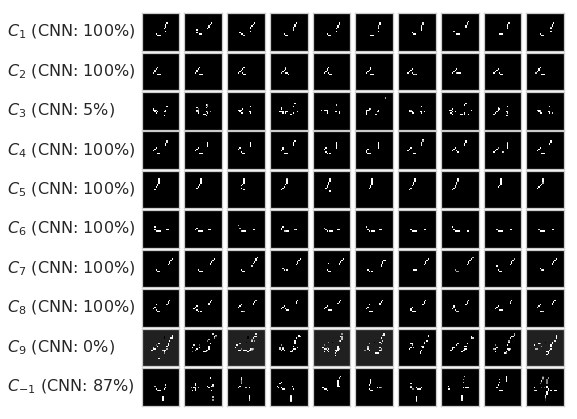

In [30]:
# Class 4 SIS Clustering (both models)

clustering.visualize_mnist_clustering(
    cluster_to_core_idxs,
    cluster_to_noncore_idxs,
    all_sis_images,
    num_examples=10,
    savepath=os.path.join(figures_dir, 'joint_clustering_cnn_mlp_digit4.png'),
    title='',
    cluster_to_name_str=cluster_to_name_str,
)

## MLP SIS Only

In [95]:
mlp_only_energy_dist_file = os.path.join(MNIST_BASEDIR, 'energy_dists', 'mlp_sis_only.npz')

In [ ]:
%%time
mlp_energy_dist_matrix = clustering.compute_energy_dists(mlp_sis)
clustering.save_matrix(mlp_energy_dist_matrix, mlp_only_energy_dist_file)

In [98]:
mlp_energy_dist_matrix = clustering.load_matrix(mlp_only_energy_dist_file)

In [103]:
cluster_to_core_idxs, cluster_to_noncore_idxs, labels = clustering.cluster(
    mlp_energy_dist_matrix,
    eps=0.42,
    min_samples=20,
)

Estimated number of clusters: 4
# core samples:  586


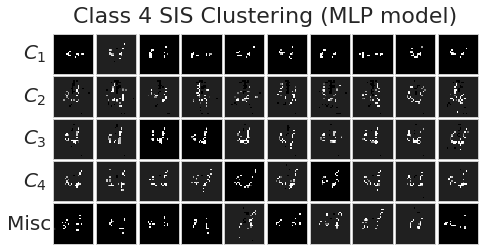

In [104]:
clustering.visualize_mnist_clustering(
    cluster_to_core_idxs,
    cluster_to_noncore_idxs,
    mlp_sis_images,
    num_examples=10,
    savepath=None,
    title='Class 4 SIS Clustering (MLP model)',
)

## Do the two model's predict each other's SISes correctly?

In [88]:
# Load CNN and MLP models

cnn_model_path = os.path.join(MNIST_BASEDIR, 'trained_models', 'model.10-0.0266.hdf5')
mlp_model_path = os.path.join(MNIST_BASEDIR, 'trained_mlp_models', 'model.12-0.0590.hdf5')

cnn_model = tf.keras.models.load_model(cnn_model_path)
mlp_model = tf.keras.models.load_model(mlp_model_path)

In [23]:
def predict_for_sis_image(model, image, digit):
    probas = model.predict(np.asarray([np.expand_dims(image, axis=-1)])).flatten()
    return probas[digit]

In [24]:
cnn_sis_preds_by_cnn = np.array([predict_for_sis_image(cnn_model, image, digit) for image in cnn_sis_images])
cnn_sis_preds_by_mlp = np.array([predict_for_sis_image(mlp_model, image, digit) for image in cnn_sis_images])

mlp_sis_preds_by_cnn = np.array([predict_for_sis_image(cnn_model, image, digit) for image in mlp_sis_images])
mlp_sis_preds_by_mlp = np.array([predict_for_sis_image(mlp_model, image, digit) for image in mlp_sis_images])

assert(np.all(cnn_sis_preds_by_cnn >= 0.7))
assert(np.all(mlp_sis_preds_by_mlp >= 0.7))

In [48]:
columns = ['method', 'predictions']

rationale_len_df = pd.DataFrame.from_dict({'MLP SIS Preds by MLP': mlp_sis_preds_by_mlp,
                                           'CNN SIS Preds by CNN': cnn_sis_preds_by_cnn,
                                           'CNN SIS Preds by MLP': cnn_sis_preds_by_mlp,
                                           'MLP SIS Preds by CNN': mlp_sis_preds_by_cnn,},
                                          orient='index').transpose()

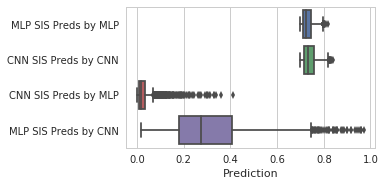

In [59]:
plt.figure(figsize=(5.5, 2.75))
sns.boxplot(data=rationale_len_df, orient='h', order=[
    'MLP SIS Preds by MLP',
    'CNN SIS Preds by CNN',
    'CNN SIS Preds by MLP',
    'MLP SIS Preds by CNN'],
            palette=sns.color_palette())
plt.xlabel('Prediction')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'sis_preds_by_other_models_digit4.png'), dpi=200, bbox_inches='tight')
plt.show()

In [30]:
def frac_above_threshold(preds, threshold):
    count_above = np.sum(np.asarray(np.asarray(preds) >= threshold, dtype=int))
    return float(count_above) / len(preds)

In [36]:
print('Max CNN SIS pred by MLP:  %.3f' % np.max(cnn_sis_preds_by_mlp))
print('Mean CNN SIS pred by MLP:  %.3f' % np.mean(cnn_sis_preds_by_mlp))
print('Frac CNN SIS pred by MLP above threshold:  %.3f' % frac_above_threshold(cnn_sis_preds_by_mlp, 0.7))
print('')
print('Max MLP SIS pred by CNN:  %.3f' % np.max(mlp_sis_preds_by_cnn))
print('Mean MLP SIS pred by CNN:  %.3f' % np.mean(mlp_sis_preds_by_cnn))
print('Frac MLP SIS pred by CNN above threshold:  %.3f' % frac_above_threshold(mlp_sis_preds_by_cnn, 0.7))

Max CNN SIS pred by MLP:  0.411
Mean CNN SIS pred by MLP:  0.028
Frac CNN SIS pred by MLP above threshold:  0.000

Max MLP SIS pred by CNN:  0.972
Mean MLP SIS pred by CNN:  0.311
Frac MLP SIS pred by CNN above threshold:  0.038


## Comparison in performance between CNN and MLP

In [90]:
def load_x_from_file(fpath, shape=(28, 28, 1)):
    x_ravel = np.loadtxt(fpath)
    x = np.array([np.reshape(x_ravel[i], shape, order='C') for i in range(x_ravel.shape[0])])
    return x

def load_y_from_file(fpath):
    y = np.loadtxt(fpath)
    return y

In [91]:
# Load processed data from files

x_train_filepath = os.path.join(DATA_DIR, 'x_train.txt.gz')
x_test_filepath = os.path.join(DATA_DIR, 'x_test.txt.gz')
y_train_filepath = os.path.join(DATA_DIR, 'y_train.txt.gz')
y_test_filepath = os.path.join(DATA_DIR, 'y_test.txt.gz')


x_train = load_x_from_file(x_train_filepath)
x_test = load_x_from_file(x_test_filepath)

y_train = load_y_from_file(y_train_filepath)
y_test = load_y_from_file(y_test_filepath)

In [92]:
cnn_score = cnn_model.evaluate(x_train, y_train, verbose=0)
print('CNN Train loss:  %.3f' % cnn_score[0])
print('CNN Train accuracy:  %.3f' % cnn_score[1])
print('')

mlp_score = mlp_model.evaluate(x_train, y_train, verbose=0)
print('MLP Train loss:  %.3f' % mlp_score[0])
print('MLP Train accuracy:  %.3f' % mlp_score[1])

CNN Train loss:  0.010
CNN Train accuracy:  0.997

MLP Train loss:  0.011
MLP Train accuracy:  0.997


In [93]:
cnn_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('CNN Test loss:  %.3f' % cnn_score[0])
print('CNN Test accuracy:  %.3f' % cnn_score[1])
print('')

mlp_score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('MLP Test loss:  %.3f' % mlp_score[0])
print('MLP Test accuracy:  %.3f' % mlp_score[1])

CNN Test loss:  0.027
CNN Test accuracy:  0.992

MLP Test loss:  0.059
MLP Test accuracy:  0.983
